In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.spatial import distance_matrix
from collections import Counter
import seaborn as sns
from IPython.core.display import display, HTML
from sklearn.metrics import accuracy_score
from func_cluster import find_min_nonzero_dist, number_of_point_within_distance, plot_silhouette
from func_cluster import configure_subplots, plot_clusters
from sklearn.metrics import adjusted_rand_score
sns.set(color_codes=True)
%matplotlib inline

display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('max_rows', 50)
pd.set_option('max_columns', 50)

In [107]:
df = pd.read_csv('hw_3_data.csv')

In [108]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,lbl
0,-0.105348,-0.765285,-0.105348,0.284124,0.430165,-0.496225,-1.630323,0.430165,-0.371408,-0.368030,0.0
1,0.078798,0.255358,0.078798,-0.464293,-0.340239,0.242046,0.539097,-0.340239,0.367130,-0.215124,0.0
2,0.138852,0.717872,0.138852,1.057301,0.130399,0.191773,1.446804,0.130399,-0.773516,1.043496,3.0
3,0.178963,0.820882,0.178963,1.750779,0.364299,-1.134097,1.618704,0.364299,-1.348497,1.469060,3.0
4,-0.928943,-0.583325,-0.928943,1.632376,1.674338,0.902454,-0.876673,1.674338,-0.345720,2.792298,2.0


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
f0     40000 non-null float64
f1     40000 non-null float64
f2     40000 non-null float64
f3     40000 non-null float64
f4     40000 non-null float64
f5     40000 non-null float64
f6     40000 non-null float64
f7     40000 non-null float64
f8     40000 non-null float64
f9     40000 non-null float64
lbl    40000 non-null float64
dtypes: float64(11)
memory usage: 3.4 MB


 *Всі дані заповнені і типу float64*

In [110]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,lbl
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-0.002991,0.003209,-0.002991,-0.009630,-0.002443,-0.006919,0.008981,-0.002443,0.012763,0.005384,1.499500
std,0.555049,0.669027,0.555049,1.473199,0.792873,1.000283,1.320918,0.792873,1.453225,1.324047,1.117668
min,-1.905599,-3.160811,-1.905599,-5.414462,-3.210632,-3.933070,-6.372736,-3.210632,-4.788817,-4.911375,0.000000
25%,-0.349748,-0.555245,-0.349748,-1.062237,-0.556013,-0.688123,-1.007493,-0.556013,-1.036148,-1.024616,1.000000
50%,-0.073417,0.037319,-0.073417,0.075740,0.081158,-0.009233,0.009509,0.081158,0.053543,0.036987,1.000000
75%,0.424013,0.531874,0.424013,1.045986,0.494282,0.671744,1.041563,0.494282,1.071657,1.014510,2.000000
max,2.782764,2.263375,2.782764,5.027650,2.735036,4.492202,4.276321,2.735036,5.395193,5.353837,3.000000


Помітно, що фічі
<br> f0 і f2,
<br>f6 і f9, 
<br>f4 і f7, 
<br>f3 і f8 
<br>мають подібні розподіли

In [111]:
df.groupby('lbl').count()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
lbl,,,,,,,,,,
0.0,9998,9998,9998,9998,9998,9998,9998,9998,9998,9998
1.0,10009,10009,10009,10009,10009,10009,10009,10009,10009,10009
2.0,10008,10008,10008,10008,10008,10008,10008,10008,10008,10008
3.0,9985,9985,9985,9985,9985,9985,9985,9985,9985,9985


*Дані збалансовані, всі класи практично рівно розподілені*

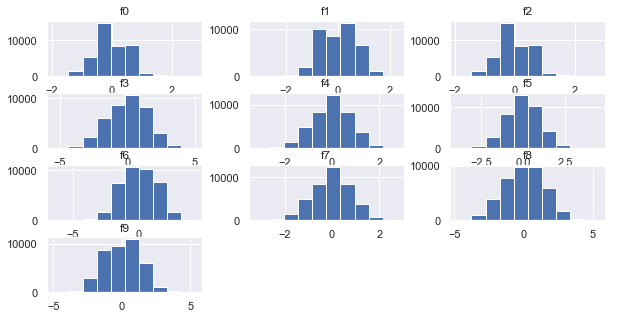

In [112]:
# розподіл значень фіч
df.iloc[:, :-1].hist(figsize=(10,5))
plt.show()

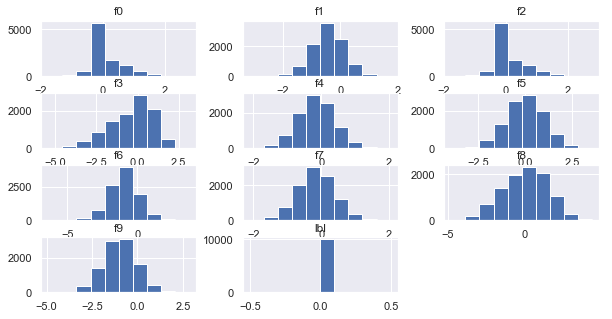

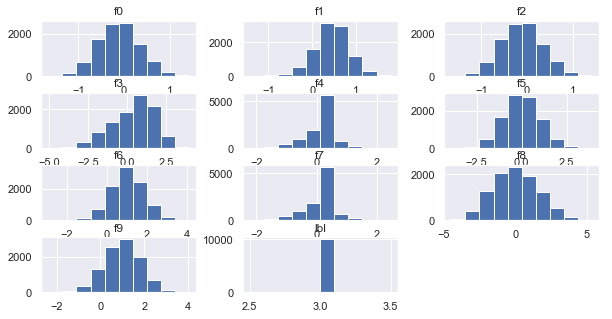

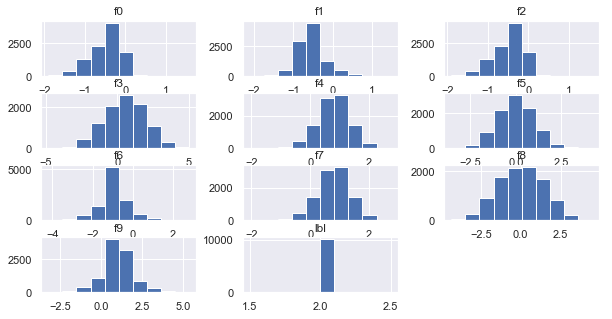

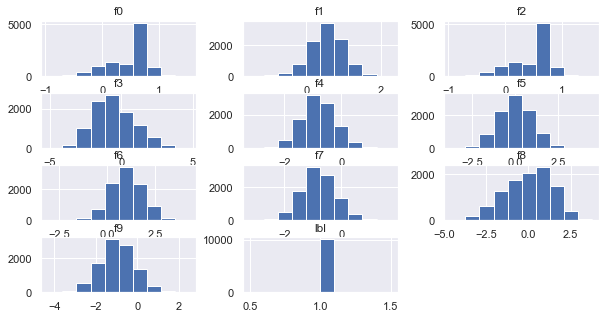

In [113]:
# гістограми для кожного класу
for l in df['lbl'].unique():
        df[df['lbl']==l].hist(figsize=(10,5))  

Помітно, що в кожному класі є викиди, і вони спотворюють розподіли
<br> - для класу 0 це викиди в f0 і f2

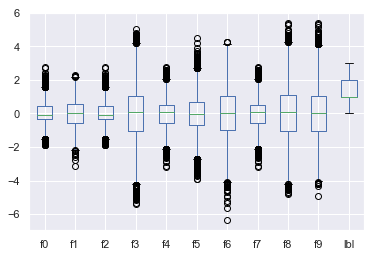

In [114]:
# аналіз викидів з допомогою боксплотів
df.plot(kind='box')

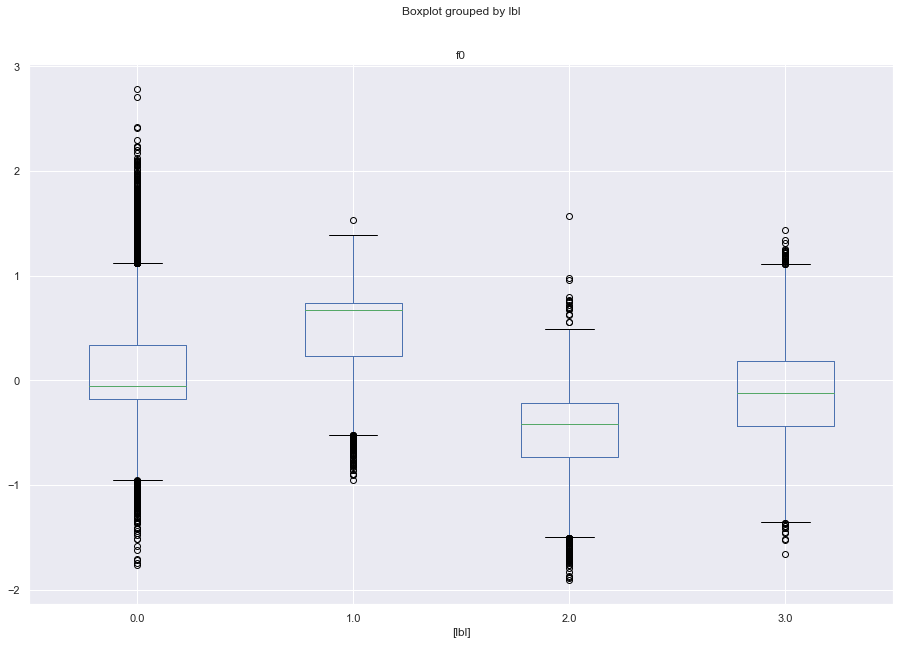

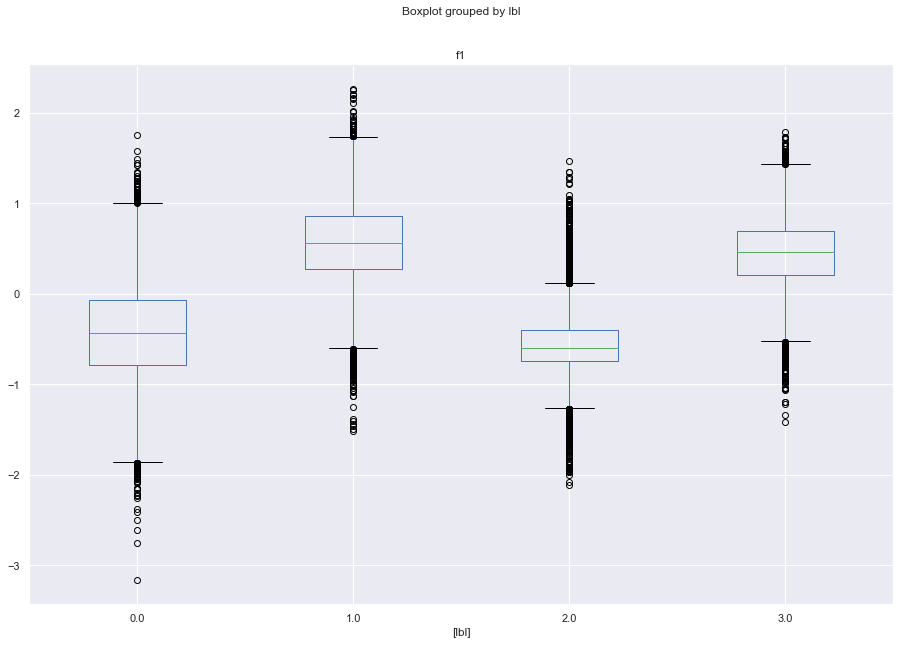

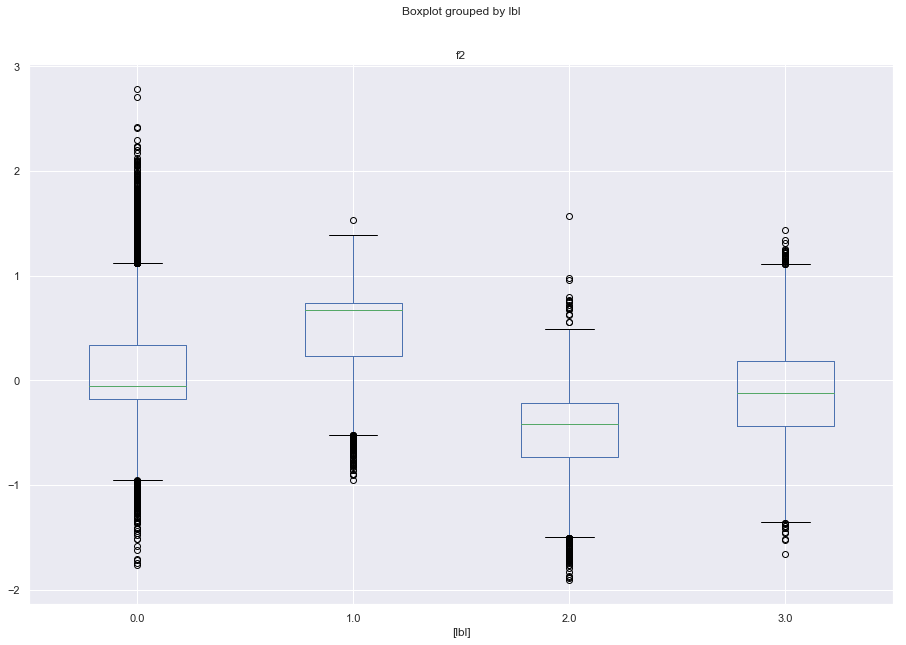

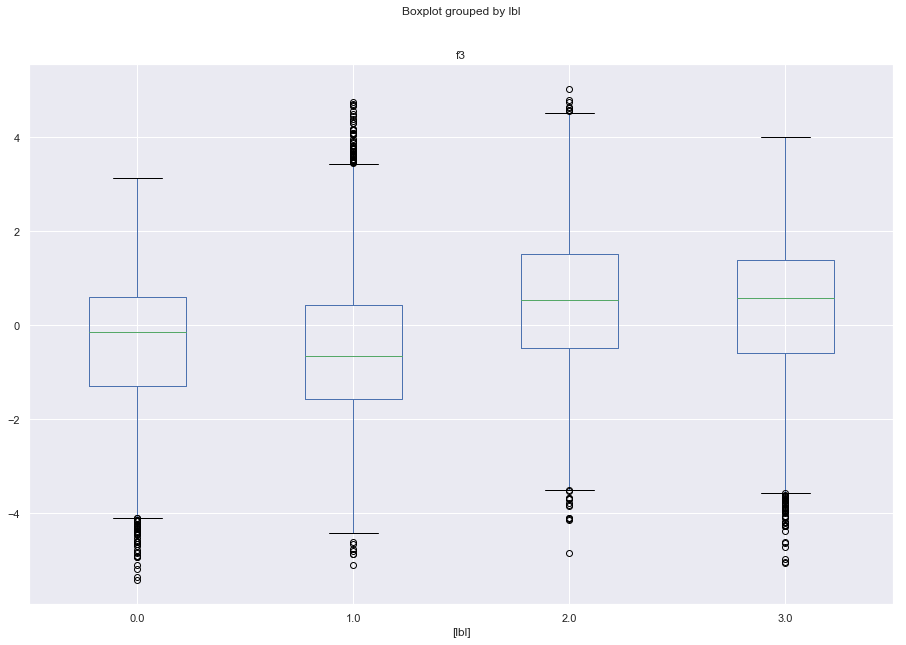

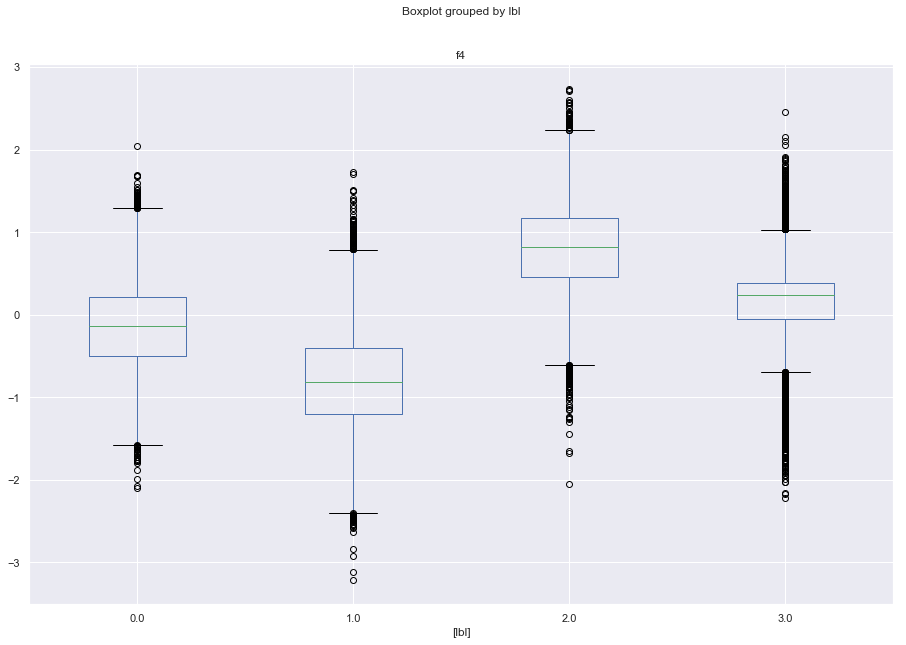

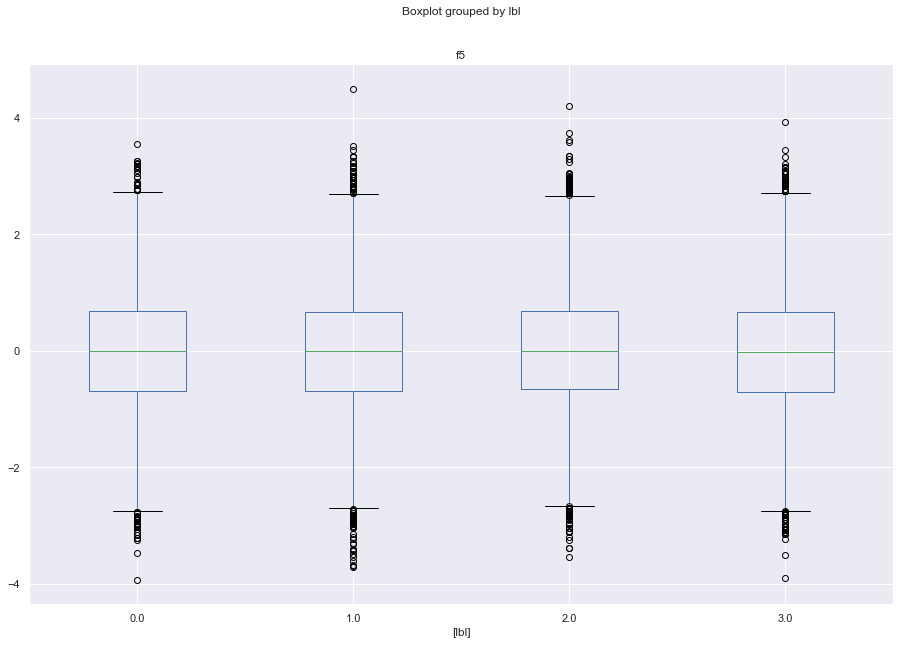

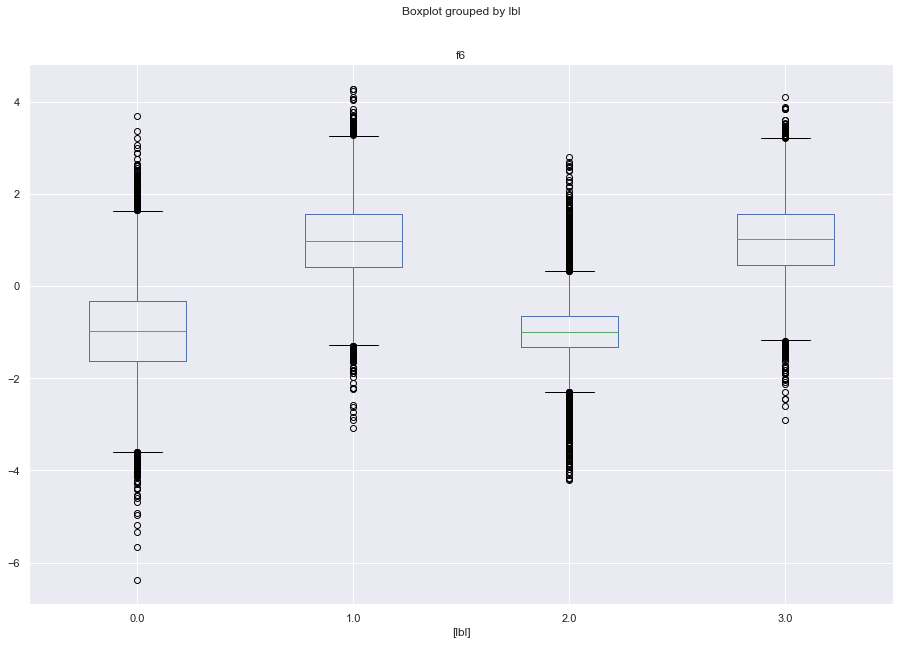

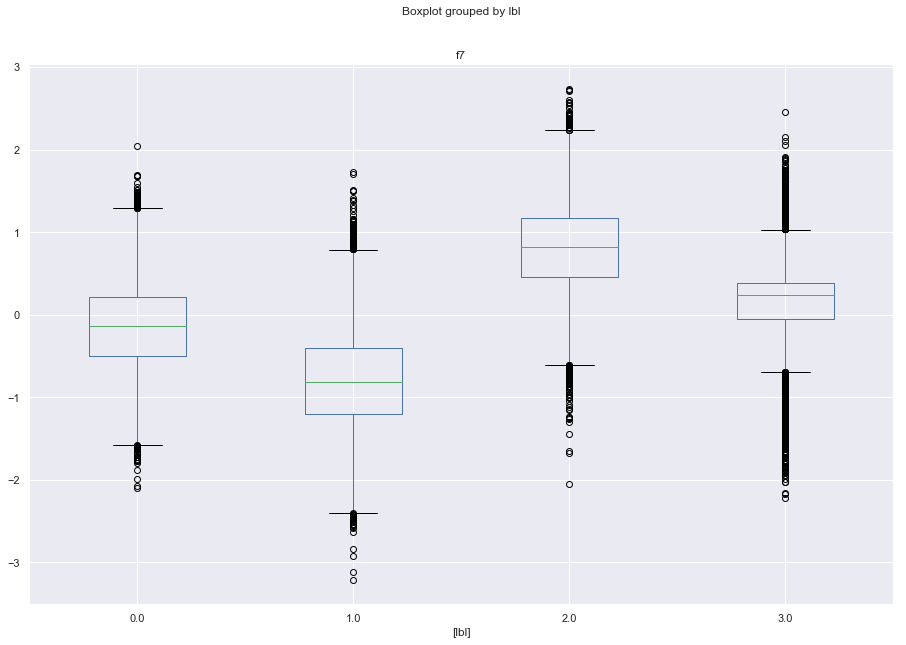

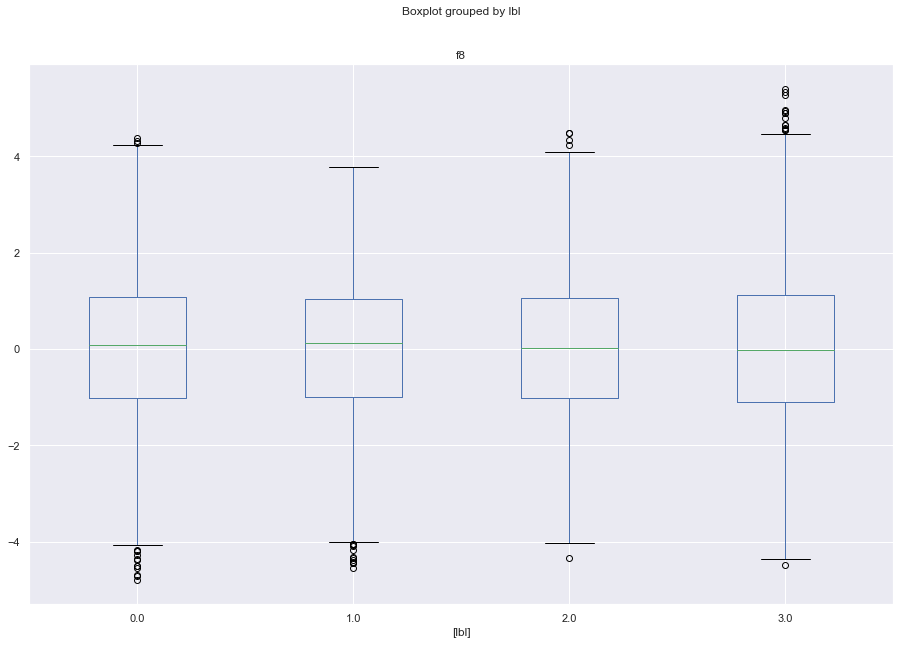

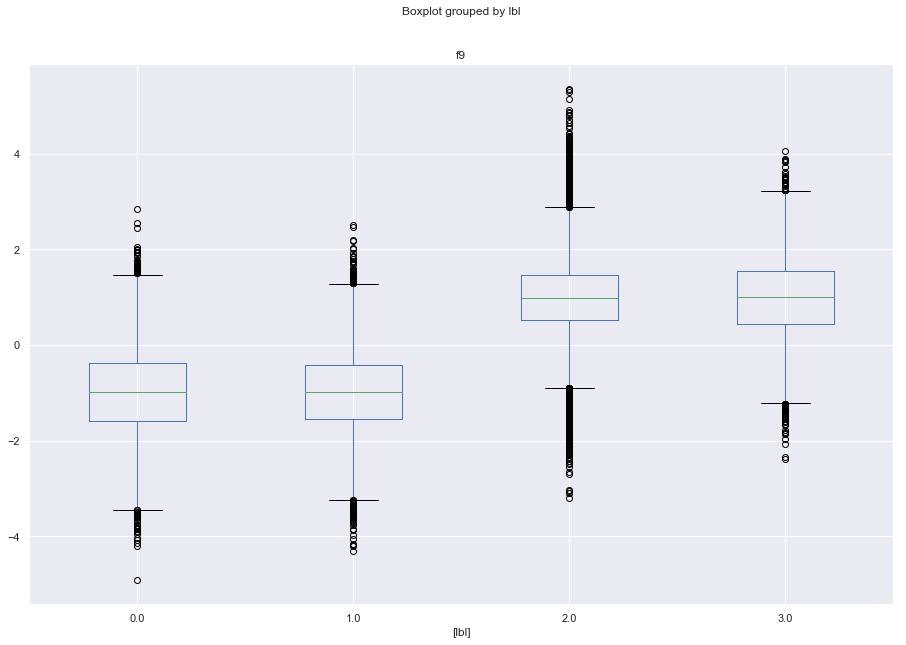

In [115]:
# викиди по кожній фічі для всіх 4 класів, добре помітно як фічі розділяють класи
for f in df.columns[:-1]:
    c = df[[f, 'lbl']].boxplot(by='lbl',figsize=(15,10), return_type='axes')
    

In [116]:
# видалення викидів IQR методом
df1 = pd.DataFrame()
for l in df['lbl'].unique():
    Q1 = df[df.lbl == l].iloc[:,:-1].quantile(0.25)
    Q3 = df[df.lbl == l].iloc[:,:-1].quantile(0.75)
    IQR = Q3 - Q1
    df1 = pd.concat([df1, df[df.lbl == l][~((df[df.lbl == l] < (Q1 - 1.5 * IQR))\
                    |(df[df.lbl == l] > (Q3 + 1.5 * IQR))).any(axis=1)]], axis=0)
df = df1
df.shape

(35673, 11)

In [117]:
#sns.pairplot(df, hue="lbl", diag_kind='hist', height=3)

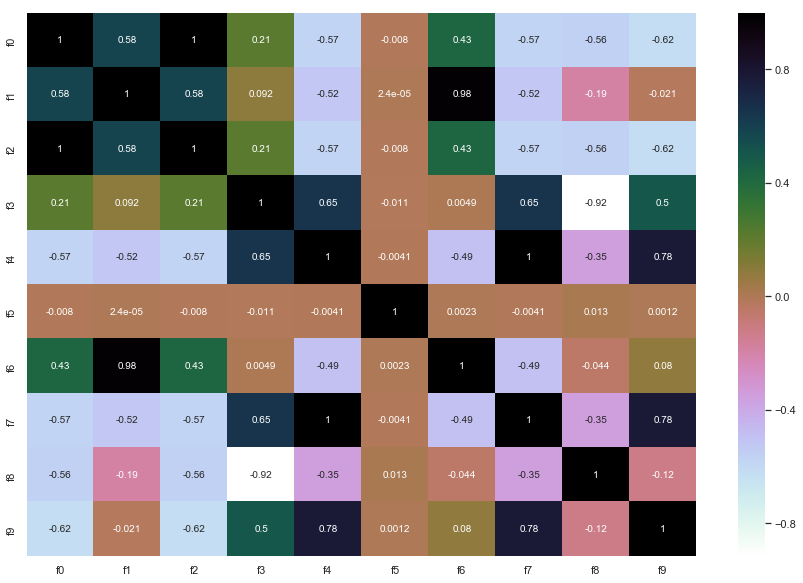

In [118]:
plt.figure(figsize=(15,10)) 
sns.heatmap(df.iloc[:, :-1].corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlation matrix calculted by(iris.corr())
plt.show()

Фічі
<br> f0 і f2,
<br>f6 і f1, 
<br>f4 і f7, 
<br>f3 і f8 
<br>мають кореляцію близьку до 1, тому одну з пари можна видалити.

In [119]:
# залишаємо фічі, які не корелюють дуже сильно між собою
df = df[['f0', 'f1', 'f3', 'f4', 'f5', 'f9', 'lbl']]
#df1 = df1[['f0', 'f1', 'f3', 'f4', 'f5', 'f9', 'lbl']]

In [120]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25, 75))
X = rs.fit_transform(df.iloc[:, :-1])
X = pd.DataFrame(X)

In [121]:
X = X.values
y = df['lbl'].values

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [61]:
from sklearn.svm import SVC

classifier2 = SVC(gamma='scale', random_state=10)
classifier2.fit(x_train,y_train)
y_pred = classifier2.predict(x_test)
print('accuracy is ',accuracy_score(y_test,y_pred))

accuracy is  0.8916090450383106


In [63]:
from sklearn.neighbors import KNeighborsClassifier

classifier3 = KNeighborsClassifier(n_neighbors=6)
classifier3.fit(x_train,y_train)
y_pred = classifier3.predict(x_test)

print('accuracy is ',accuracy_score(y_test,y_pred))

accuracy is  0.8911418426462343


In [20]:
# Bayesian optimization
from sklearn.model_selection import cross_val_score

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

In [21]:
def svc_cv(C, gamma, k, data, targets):
    i = int(round(k,0))
    l = ['linear', 'poly', 'rbf', 'precomputed']
    estimator = SVC(C=C, gamma=gamma, kernel=l[i], random_state=2)
    cval = cross_val_score(estimator, data, targets, scoring='accuracy', cv=3)
    return cval.mean()

In [52]:
def optimize_svc(data, targets):
    """Apply Bayesian Optimization to SVC parameters."""
    def svc_crossval(expC, expGamma, k):
        C = 10 ** expC
        gamma = 10 ** expGamma
        return svc_cv(C=C, gamma=gamma, k=2, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={"expC": (1, 3), "expGamma": (-1, 1), 'k':(0, 3)},
        random_state=1234
    )
    optimizer.maximize(n_iter=5)
    print("Final result:", optimizer.max)

optimize_svc(X, y)

|   iter    |  target   |   expC    | expGamma  |     k     |
-------------------------------------------------------------
|  1        |  0.9042   |  1.383    |  0.2442   |  1.313    |
|  2        |  0.8829   |  2.571    |  0.56     |  0.8178   |
|  3        |  0.8964   |  1.553    |  0.6037   |  2.874    |
|  4        |  0.9039   |  2.752    | -0.2844   |  1.503    |
|  5        |  0.8941   |  2.367    |  0.4254   |  1.111    |
|  6        |  0.8851   |  1.0      | -1.0      |  0.0      |
|  7        |  0.8851   |  1.0      | -1.0      |  3.0      |
|  8        |  0.8975   |  3.0      | -1.0      |  3.0      |
|  9        |  0.8941   |  2.223    | -1.0      |  1.533    |
|  10       |  0.8551   |  3.0      |  1.0      |  3.0      |
Final result: {'target': 0.904185028848045, 'params': {'expC': 1.3830389007577846, 'expGamma': 0.24421754207966373, 'k': 1.3131832170213436}}


Найкращі показники для C = 10^1.38, gamma=10^0.244, kernel = 'rbf', -> accuracy = 0.904. Результат покращився на 0.088

In [24]:
estimator = SVC(C=10**1.383, gamma=10**0.2442, kernel='rbf', random_state=2)
cval = cross_val_score(estimator, X, y, scoring='accuracy', cv=3)
cval.mean()

0.904185028848045

In [25]:
# оптимізація параметрів для KNN
n = [i for i in range(1, 20)]
L = []
for i in n:
    estimator2 = KNeighborsClassifier(n_neighbors=i)
    cval = cross_val_score(estimator2, X, y, scoring='accuracy', cv=3)
    L.append((i, cval.mean()))

In [29]:
L

[(1, 0.8707145011299198),
 (2, 0.868556090742656),
 (3, 0.8868891428112923),
 (4, 0.8882348256223507),
 (5, 0.8913743419351619),
 (6, 0.8912343072092211),
 (7, 0.8938131565231048),
 (8, 0.891766861612207),
 (9, 0.8926638373052143),
 (10, 0.8915144898058861),
 (11, 0.8918789157941491),
 (12, 0.8917387207570316),
 (13, 0.8918788969282262),
 (14, 0.8919349758925549),
 (15, 0.8927479250902212),
 (16, 0.8914865186996073),
 (17, 0.892383414233854),
 (18, 0.8912341091598547),
 (19, 0.892047011203816)]

Найкращий показник accuracy для n_neighbors=7, accuracy = 0.8938, відбулося незначне покращення на 0.002

# Кластеризація

# KMeans

For n_clusters = 8 The average silhouette_score is : 0.13705148220518304


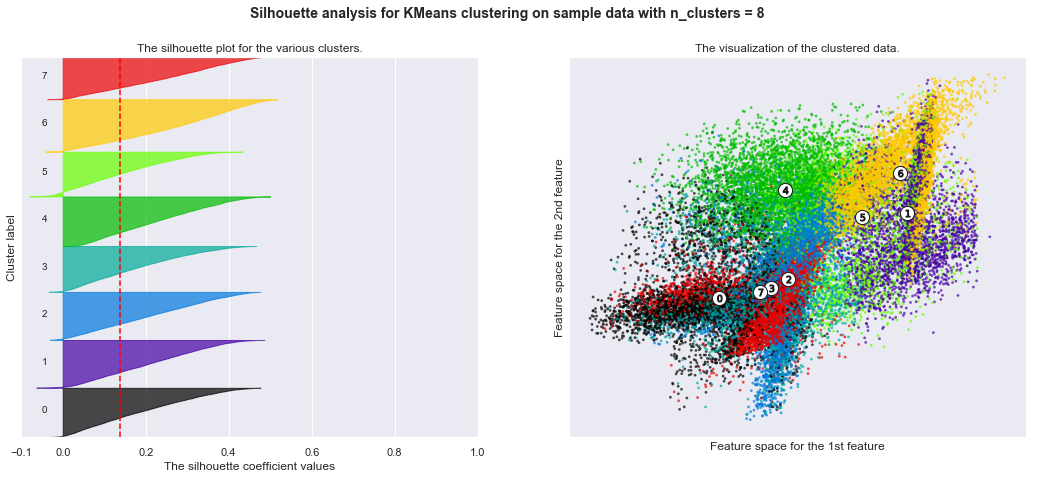

In [39]:
# Будуємо Kmeans для 8 кластерів, визначаємо silhouette score

range_n_clusters = [8]

for n_clusters in range_n_clusters:

    silhouette_avg = silhouette_score(X, y)    
    ax1, ax2 = configure_subplots(len(X), n_clusters, silhouette_avg, y)    
    clusterer = KMeans(n_clusters, random_state=10)
    pred_cluster_labels = clusterer.fit_predict(X)
    sample_silhouette_values = silhouette_samples(X, pred_cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        y_lower = plot_silhouette(ax1, i, pred_cluster_labels, 
                                  sample_silhouette_values, n_clusters)
    
    centers = clusterer.cluster_centers_
    plot_clusters(X, pred_cluster_labels, centers, ax2)
plt.show()

# DBScan

In [91]:
def find_min_nonzero_dist(data_full, x):
    # Make every point the size of (1,2)
    dist_vect = distance_matrix(data_full, [x])
    # Don't count if the distance is 0 - it may be the same point
    nonzero_elems = dist_vect[np.nonzero(dist_vect)]   
    return np.min(nonzero_elems)

def number_of_point_within_distance(data, dist):
    # Find number of closest neighbors around every point of data, 
    # that falls into a sphere of radius = dist
    result = np.array([])
    for x in data:
        dist_vect = distance_matrix(data, [x])
        filtered_elems = dist_vect[dist_vect <= dist]
        # -1 because the point has zero distance to itself, don't count it 
        count = filtered_elems.shape[0] - 1 
        result = np.append(result, count) 
    return result

(array([5.800e+01, 2.970e+02, 9.530e+02, 2.002e+03, 3.060e+03, 4.161e+03,
        4.528e+03, 4.327e+03, 3.725e+03, 3.032e+03, 2.294e+03, 1.805e+03,
        1.342e+03, 1.009e+03, 7.110e+02, 5.800e+02, 4.080e+02, 3.040e+02,
        2.760e+02, 1.810e+02, 1.280e+02, 9.800e+01, 6.900e+01, 6.900e+01,
        5.200e+01, 3.500e+01, 3.400e+01, 2.500e+01, 2.000e+01, 2.200e+01,
        1.500e+01, 1.400e+01, 8.000e+00, 7.000e+00, 5.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.00879482, 0.02240198, 0.03600914, 0.0496163 , 0.06322346,
        0.07683062, 0.09043778, 0.10404493, 0.11765209, 0.13125925,
        0.14486641, 0.15847357, 0.17208073, 0.18568789, 0.19929504,
        0.2129022 , 0.22650936, 0.24011652, 0.25372368, 0.26733084,
        0.280938  , 0.29454516, 0.30815231, 0.32175947, 0.33536663,
        0.34897379, 0.36258095, 0.37

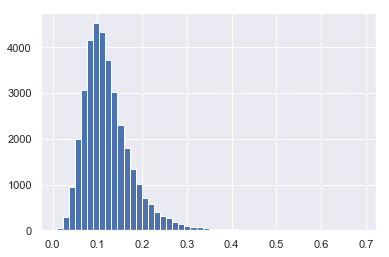

In [86]:
# знайти оптимальний епсілон
min_distances = np.apply_along_axis(lambda x: find_min_nonzero_dist(X, x), 
                                  axis=1,
                                  arr=X)
# Visualize distribution of distances to the closest neighbors
plt.hist(min_distances)

### Обираємо епсілон 0.2, яке охоплює більшу частину мінміальних відстаней

In [103]:
epsilon = 0.2

In [98]:
# знайти оптимальну кількість точок
num_points = number_of_point_within_distance(X, epsilon)

(array([3.034e+03, 3.094e+03, 2.855e+03, 2.597e+03, 2.326e+03, 2.161e+03,
        1.959e+03, 1.790e+03, 1.710e+03, 1.540e+03, 1.338e+03, 1.324e+03,
        1.196e+03, 1.064e+03, 1.035e+03, 8.880e+02, 7.970e+02, 7.130e+02,
        6.490e+02, 5.590e+02, 4.770e+02, 4.320e+02, 3.270e+02, 2.910e+02,
        2.790e+02, 2.380e+02, 2.000e+02, 1.800e+02, 1.190e+02, 9.300e+01,
        8.800e+01, 7.400e+01, 4.700e+01, 5.200e+01, 2.000e+01, 2.800e+01,
        3.000e+01, 1.900e+01, 1.300e+01, 9.000e+00, 6.000e+00, 4.000e+00,
        4.000e+00, 5.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>)

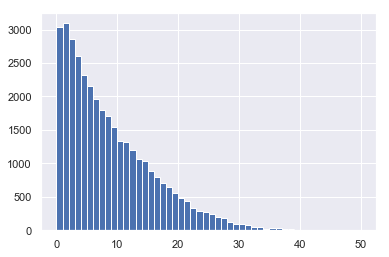

In [99]:
plt.hist(num_points, bins=50)

### Немає різницю яку кількість точок брати, кластери не розділяються

In [104]:
min_pts = 15

Silhouette score -0.6046418280586818
Adjested rand score 0.011332840582245544


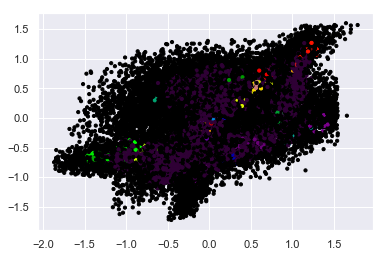

In [105]:
dbscan = DBSCAN(eps=epsilon, min_samples=min_pts)
pred = dbscan.fit_predict(X)
plot_clusters(X, pred+1)
print('Silhouette score', silhouette_score(X, pred))
print( 'Adjested rand score', adjusted_rand_score(y, pred))

### Точки близько, густина майже не міняється, тому дані сприймаються як один кластер